# Level 1: Rice Crop Discovery Tool Benchmark Notebook

## Challenge Level 1 Overview

<p align="justify">Welcome to the EY Open Science Data Challenge 2023! This challenge consists of two levels – Level 1 and Level 2. This is the Level 1 challenge aimed at participants who are beginners or have intermediate skill sets in data science and programming. The goal of Level 1 is to predict the presence of rice crops at a given location using satellite data. By the time you complete this level, you will have developed a rice crop classification model, which can distinguish between rice and non-rice fields. 
</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been built to predict rice crops against non-rice crops (which might include forest, other vegetation and water bodies) using features from the Sentinel-1 Radiometrically Terrain Corrected (RTC)  dataset as predictor variables. In this demonstration, we have used two features from the Sentinel-1 dataset, namely VV (Vertical polarization – Vertical polarization) and VH (Vertical polarization – Horizontal polarization) and trained a logistic regression model with these features. We have extracted the VV band and VH band data from the Sentinel-1 dataset for one day (21st March 2020), with an assumption that VV and VH values for this day are representative of VV and VH values for the entire year (2020) for a given location.

Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc#Example-Notebook">Sentinel-1-RTC notebook</a> found in the Planetary Computer portal.</p>
    
<p align="justify"> Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

#### Note: Environment setup
Running this notebook requires an API key.

To use your API key locally, set the environment variable <i><b>PC_SDK_SUBSCRIPTION_KEY</i></b> or use <i><b>planetary_computer.settings.set_subscription_key(<YOUR API Key>)</i></b><br>
See <a href="https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed">when an account is needed for more </a>, and <a href="https://planetarycomputer.microsoft.com/account/request">request</a> an account if needed.

# Import Libraries

In [1]:
pip install tabpfn

  Using cached tabpfn-0.1.8-py3-none-any.whl (153 kB)
  Using cached torch-2.0.0-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached triton-2.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
  Using cached nvidia_cusolver_cu11-11.4.0.1-2-py3-none-manylinux1_x86_64.whl (102.6 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
# System
import warnings
import rasterio.errors
import time

# Utils
#from utils import download_sentinel_data
from utils import convert_coordinates, download_sentinel_data
#import utils

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Machine Learning
from sklearn.linear_model import LogisticRegression
from tabpfn import TabPFNClassifier
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
import joblib

# Planetary Computer Tools
#import pystac
#import pystac_client
#import odc
#from pystac_client import Client
#from pystac.extensions.eo import EOExtension as eo
#from odc.stac import stac_load
#import planetary_computer as pc
#pc.settings.set_subscription_key('100bbb6552514f27a2e52ef1be8d93b6')  # SJ's primary key

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

In [3]:
# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 10)

## Response Variable

Before building the model, we need to load in the rice crop presence data. We have curated for you data from a certain region in Vietnam for the year 2020. The data consists of  geo locations (Latitude and Longitude) with a tag specifying if the crop present in each geo location is rice or not.

# Load Data

In [57]:
crop_presence_data = pd.read_csv("Crop_Location_Data.csv")
crop_presence_data.head(11)

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice
5,"(10.323727047081501, 105.28070524968936)",Rice
6,"(10.325089733570481, 105.23937042619212)",Rice
7,"(10.324181275911162, 105.25390574874059)",Rice
8,"(10.321001674103542, 105.24436694331814)",Rice
9,"(10.321001674103542, 105.2416415703403)",Rice


There's missing parathesis on line 11: (10.324635504740822, 105.25572266405916) -> we created a function to fix this in Utils.py

In [58]:
crop_presence_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Latitude and Longitude  600 non-null    object
 1   Class of Land           600 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


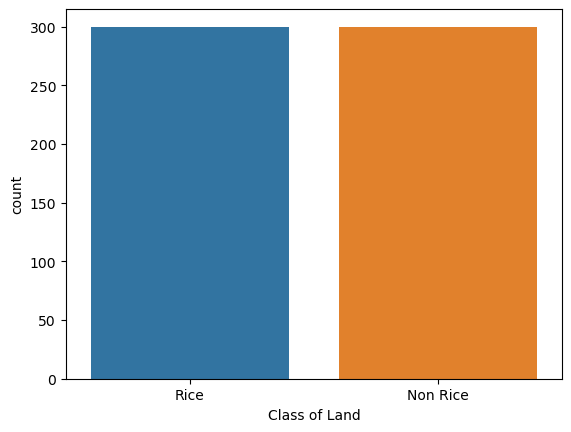

In [59]:
# Check for class imbalance
sns.countplot(x=crop_presence_data['Class of Land'])
plt.show()

The dataset seems perfectly balanced, hence we can use accuracy or F1 score as the main metrics.

In [60]:
# Verify
crop_presence_data['Class of Land'].count()

600

## Predictor Variables

<p align ="justify">Now that we have our crop location data, it is time to gather the predictor variables from the Sentinel-1 dataset. For a more in-depth look regarding the Sentinel-1 dataset and how to query it, see the Sentinel-1 <a href="https://challenge.ey.com/api/v1/storage/admin-files/6403146221623637-63ca8d537b1fe300146c79d0-Sentinel%201%20Phenology.ipynb/"> supplementary 
notebook</a>.
    

<p align = "justify">Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation. Band values such as VV and VH help us in distinguishing between the rice and non rice crops. Hence we are choosing VV and VH as predictor variables for this experiment. 
        
<ul>
<li>VV - gamma naught values of signal transmitted with vertical polarization and received with vertical polarization with radiometric terrain correction applied.

<li>VH - gamma naught values of signal transmitted with vertical polarization and received with horizontal polarization with radiometric terrain correction applied.
</ul>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-1 data. For example, you can use mathematical combinations of bands to generate various <a href="https://challenge.ey.com/api/v1/storage/admin-files/3868217534768359-63ca8dc8aea56e00146e3489-Comprehensive%20Guide%20-%20Satellite%20Data.docx">vegetation indices </a> which can then be used as features in your model.


RVI = sqrt (1- VV / (VV+VH)) * 4 * (VH / (VV + VH))

### Accessing the Sentinel-1 Data

<p align = "Justify">To get the Sentinel-1 data, we write a function called <i><b>get_sentinel_data.</b></i> This function will fetch VV and VH band values for a particular location over the specified time window. In this example, we have extracted VV and VH values for a day (21st March 2020). </p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 2</strong></h4>
<p align="justify"> Extract VV and VH band values for an entire year. Different land classes (e.g., agriculture, water, urban) will have different annual variability. This variability will be better than a single date for accurately identifying land classes. Please find below a demonstration of extracting data for a day (21st March 2020).

# Pre-processing

In [61]:
# Create a new working dataframe 
crop_data = convert_coordinates(crop_presence_data, 'Latitude and Longitude')
crop_data.head(11)

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice
5,"(10.323727047081501, 105.28070524968936)",Rice
6,"(10.325089733570481, 105.23937042619212)",Rice
7,"(10.324181275911162, 105.25390574874059)",Rice
8,"(10.321001674103542, 105.24436694331814)",Rice
9,"(10.321001674103542, 105.2416415703403)",Rice


<h4 style="color:rgb(195, 52, 235)"><strong>Tip 3 </strong></h4>

Explore the approach of building a bounding box (e.g., 5x5 pixels) around the given latitude and longitude positions and then extract the aggregated band values (e.g., average, median) to get normalized band values to build the model. Radar data has inherent variability at the pixel level due to variable scattering response from the target. This effect is called “speckle” and it is common to filter the data to smooth these variations. Try using a 3x3, 5x5 or 7x7 window around the specific latitude and longitude point to get improved results.

## Load data

In [62]:
clusters_df = pd.read_csv('time_series_clustering.csv')
clusters_df.shape

(600, 16)

In [63]:
clusters_df

,2022-01-01/2022-02-01,2022-02-01/2022-03-01,2022-03-01/2022-04-01,2022-04-01/2022-05-01,2022-05-01/2022-06-01,2022-06-01/2022-07-01,2022-07-01/2022-08-01,2022-08-01/2022-09-01,2022-09-01/2022-10-01,2022-10-01/2022-11-01,2022-11-01/2022-12-01,2022-12-01/2023-01-01,Cluster,Mean,Variance,Autocorrelation
0,0.000000,0.841573,0.807760,0.696798,0.883964,0.803519,0.715134,0.668195,0.841399,0.848658,0.722617,0.645882,0,0.795133,0.015904,0.088636
1,0.000000,0.846314,0.790300,0.612413,0.814059,0.849617,0.695019,0.582343,0.921048,0.960702,0.728509,0.576973,0,0.795133,0.015904,0.088636
2,0.000000,0.863479,0.859740,0.522208,0.851382,0.941563,0.714716,0.501355,1.032338,1.082728,0.702156,0.509662,2,0.764986,0.010336,-0.105744
3,0.000000,0.895227,0.901925,0.431608,0.834731,0.971780,0.668375,0.404303,1.065914,1.119994,0.654099,0.428628,2,0.764986,0.010336,-0.105744
4,0.000000,0.908831,0.907711,0.352323,0.823155,0.988167,0.644748,0.312362,1.138900,1.176872,0.589190,0.369074,2,0.764986,0.010336,-0.105744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.752385,0.689097,0.847629,0.790360,0.719185,0.810933,0.742411,0.838833,0.871095,0.881471,0.734563,0.868102,5,1.058320,0.047663,0.252870
596,0.756037,0.689809,0.825594,0.812744,0.725924,0.793907,0.755886,0.834033,0.882235,0.868649,0.744769,0.870922,5,1.058320,0.047663,0.252870
597,0.797909,0.714623,0.797313,0.833137,0.727818,0.768287,0.772935,0.814500,0.876773,0.851259,0.734648,0.824893,3,0.833722,0.027239,-0.383943
598,0.827928,0.729042,0.786258,0.825661,0.722673,0.761182,0.767620,0.781230,0.843765,0.827501,0.743321,0.812216,3,0.833722,0.027239,-0.383943


In [65]:
ndvi_df =  pd.read_csv('data_s2_ndvi.csv')
ndvi_df.shape

(601, 70)

In [66]:
# Drop first row (header)
ndvi_df = ndvi_df.iloc[1:]
ndvi_df.shape

(600, 70)

In [67]:
# Take only the NDVI time series statistics
ndvi_df = ndvi_df.iloc[:,64:].reset_index()
ndvi_df.shape

(600, 7)

In [68]:
df = pd.concat([clusters_df, ndvi_df, crop_data['Class of Land']], axis=1)
df.shape

(600, 24)

In [69]:
df.head()

,2022-01-01/2022-02-01,2022-02-01/2022-03-01,2022-03-01/2022-04-01,2022-04-01/2022-05-01,2022-05-01/2022-06-01,2022-06-01/2022-07-01,2022-07-01/2022-08-01,2022-08-01/2022-09-01,2022-09-01/2022-10-01,2022-10-01/2022-11-01,2022-11-01/2022-12-01,2022-12-01/2023-01-01,Cluster,Mean,Variance,Autocorrelation,index,max_value,min_value,mean,std_dev,variance,autocorrelation,Class of Land
0,0.0,0.841573,0.807760,0.696798,0.883964,0.803519,0.715134,0.668195,0.841399,0.848658,0.722617,0.645882,0,0.795133,0.015904,0.088636,1,0.7215846012082436,-0.029840347174265553,0.19936941578625544,0.19026711963569642,0.035662473181210595,0.08894905375171254,Rice
1,0.0,0.846314,0.790300,0.612413,0.814059,0.849617,0.695019,0.582343,0.921048,0.960702,0.728509,0.576973,0,0.795133,0.015904,0.088636,2,0.7044807394355972,-0.025654203148400796,0.19621899415350655,0.18534437478371033,0.03384155190581298,0.05762773373370373,Rice
2,0.0,0.863479,0.859740,0.522208,0.851382,0.941563,0.714716,0.501355,1.032338,1.082728,0.702156,0.509662,2,0.764986,0.010336,-0.105744,3,0.7228931190448608,-0.02999531104189721,0.1991496905978574,0.19051068104621238,0.03575371086667349,0.08447523694123793,Rice
3,0.0,0.895227,0.901925,0.431608,0.834731,0.971780,0.668375,0.404303,1.065914,1.119994,0.654099,0.428628,2,0.764986,0.010336,-0.105744,4,0.7215223227960891,-0.029973211653726822,0.19950248031860973,0.190288272983019,0.035670433196483484,0.09037753099337853,Rice
4,0.0,0.908831,0.907711,0.352323,0.823155,0.988167,0.644748,0.312362,1.138900,1.176872,0.589190,0.369074,2,0.764986,0.010336,-0.105744,5,0.704632516034935,-0.02534338715856283,0.1970163673037325,0.18622468902602612,0.03416374096501096,0.06385118715905538,Rice


## Load data 2 (with NDVI)

In [19]:
data_clusters_df = pd.read_csv('data_time_series_clustering.csv')
data_clusters_df.shape

(600, 18)

In [20]:
data_clusters_df.head()

,Latitude and Longitude,Class of Land,2022-01-01/2022-02-01,2022-02-01/2022-03-01,2022-03-01/2022-04-01,2022-04-01/2022-05-01,2022-05-01/2022-06-01,2022-06-01/2022-07-01,2022-07-01/2022-08-01,2022-08-01/2022-09-01,2022-09-01/2022-10-01,2022-10-01/2022-11-01,2022-11-01/2022-12-01,2022-12-01/2023-01-01,Cluster,Mean,Variance,Autocorrelation
0,"(10.323727047081501, 105.2516346045924)",Rice,0.0,0.841573,0.807760,0.696798,0.883964,0.803519,0.715134,0.668195,0.841399,0.848658,0.722617,0.645882,0,0.795133,0.015904,0.088636
1,"(10.322364360592521, 105.27843410554115)",Rice,0.0,0.846314,0.790300,0.612413,0.814059,0.849617,0.695019,0.582343,0.921048,0.960702,0.728509,0.576973,0,0.795133,0.015904,0.088636
2,"(10.321455902933202, 105.25254306225168)",Rice,0.0,0.863479,0.859740,0.522208,0.851382,0.941563,0.714716,0.501355,1.032338,1.082728,0.702156,0.509662,2,0.764986,0.010336,-0.105744
3,"(10.324181275911162, 105.25118037576274)",Rice,0.0,0.895227,0.901925,0.431608,0.834731,0.971780,0.668375,0.404303,1.065914,1.119994,0.654099,0.428628,2,0.764986,0.010336,-0.105744
4,"(10.324635504740822, 105.27389181724476)",Rice,0.0,0.908831,0.907711,0.352323,0.823155,0.988167,0.644748,0.312362,1.138900,1.176872,0.589190,0.369074,2,0.764986,0.010336,-0.105744


In [50]:
df = pd.concat([data_clusters_df, ndvi_df], axis=1)
df.shape

(600, 25)

In [51]:
df.head()

,Latitude and Longitude,Class of Land,2022-01-01/2022-02-01,2022-02-01/2022-03-01,2022-03-01/2022-04-01,2022-04-01/2022-05-01,2022-05-01/2022-06-01,2022-06-01/2022-07-01,2022-07-01/2022-08-01,2022-08-01/2022-09-01,2022-09-01/2022-10-01,2022-10-01/2022-11-01,2022-11-01/2022-12-01,2022-12-01/2023-01-01,Cluster,Mean,Variance,Autocorrelation,index,max_value,min_value,mean,std_dev,variance,autocorrelation
0,"(10.323727047081501, 105.2516346045924)",Rice,0.0,0.841573,0.807760,0.696798,0.883964,0.803519,0.715134,0.668195,0.841399,0.848658,0.722617,0.645882,0,0.795133,0.015904,0.088636,1,0.7215846012082436,-0.029840347174265553,0.19936941578625544,0.19026711963569642,0.035662473181210595,0.08894905375171254
1,"(10.322364360592521, 105.27843410554115)",Rice,0.0,0.846314,0.790300,0.612413,0.814059,0.849617,0.695019,0.582343,0.921048,0.960702,0.728509,0.576973,0,0.795133,0.015904,0.088636,2,0.7044807394355972,-0.025654203148400796,0.19621899415350655,0.18534437478371033,0.03384155190581298,0.05762773373370373
2,"(10.321455902933202, 105.25254306225168)",Rice,0.0,0.863479,0.859740,0.522208,0.851382,0.941563,0.714716,0.501355,1.032338,1.082728,0.702156,0.509662,2,0.764986,0.010336,-0.105744,3,0.7228931190448608,-0.02999531104189721,0.1991496905978574,0.19051068104621238,0.03575371086667349,0.08447523694123793
3,"(10.324181275911162, 105.25118037576274)",Rice,0.0,0.895227,0.901925,0.431608,0.834731,0.971780,0.668375,0.404303,1.065914,1.119994,0.654099,0.428628,2,0.764986,0.010336,-0.105744,4,0.7215223227960891,-0.029973211653726822,0.19950248031860973,0.190288272983019,0.035670433196483484,0.09037753099337853
4,"(10.324635504740822, 105.27389181724476)",Rice,0.0,0.908831,0.907711,0.352323,0.823155,0.988167,0.644748,0.312362,1.138900,1.176872,0.589190,0.369074,2,0.764986,0.010336,-0.105744,5,0.704632516034935,-0.02534338715856283,0.1970163673037325,0.18622468902602612,0.03416374096501096,0.06385118715905538


## Feature Engineering

In [70]:
# replacing values
df['Class of Land'].replace(['Rice', 'Non Rice'],
                        [1, 0], inplace=True)

# Model Building


In [71]:
X = df.drop('Class of Land', axis=1)
y = df['Class of Land']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Baseline Model

In [20]:
!pip install tabpfn

In [76]:
# N_ensemble_configurations controls the number of model predictions that are ensembled with feature and class rotations (See our work for details).
# When N_ensemble_configurations > #features * #classes, no further averaging is applied.
from tabpfn import TabPFNClassifier

classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=32)

start = time.time()
classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)
print('Prediction time: ', time.time() - start, ' Model score: %.3f' % classifier.score(X_test, y_test))

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Prediction time:  9.143781661987305  Model score: 1.000


In [77]:
classifier.predict_proba(X_test).shape

(60, 2)

In [78]:
out_table = pd.DataFrame(X_test.copy().astype(str))
out_table['prediction'] = [f"{y_e} (p={p_e:.2f})" for y_e, p_e in zip(y_eval, p_eval)]
out_table.head()

,2022-01-01/2022-02-01,2022-02-01/2022-03-01,2022-03-01/2022-04-01,2022-04-01/2022-05-01,2022-05-01/2022-06-01,2022-06-01/2022-07-01,2022-07-01/2022-08-01,2022-08-01/2022-09-01,2022-09-01/2022-10-01,2022-10-01/2022-11-01,2022-11-01/2022-12-01,2022-12-01/2023-01-01,Cluster,Mean,Variance,Autocorrelation,index,max_value,min_value,mean,std_dev,variance,autocorrelation,prediction
110,0.5348545207857958,0.9421707684471256,1.0762900955314905,0.2245204127617848,0.8679519848000445,1.2248699987408425,0.7165897488730614,0.4977991366578046,1.0875022412073083,1.2289048382061272,0.6403657959324115,0.2693246058741095,2,0.7649858416313423,0.0103358255244773,-0.10574372770967,111,0.7046336451152437,-0.025598918630326987,0.19526547952234238,0.18385853958023213,0.03330133932580215,0.05275912032223182,1 (p=1.00)
419,1.0578549949428642,0.9592750401877098,0.6473406011481272,0.8313849549801041,0.9552881699058408,0.7025693020648207,1.109501086051393,0.8667143226887253,0.8387117640790803,0.9389106741970628,0.9456165347358024,0.871250049593354,3,0.8337218301009401,0.0272386921391738,-0.3839427258488748,420,0.5461615864211345,-0.02476569341836696,0.12811930064486446,0.11981238689495177,0.01414176897862795,-0.0753806656834246,0 (p=1.00)
565,0.819956611981578,0.7925596192691,0.8668563963298409,0.7728406232767469,0.8231206954240156,0.8727121050834263,0.7734310524489343,0.8517025622088451,0.7822073430679487,0.9307470681177056,0.8214191573341937,0.829024261990279,5,1.0583195459207055,0.04766262405394,0.2528699182046113,566,0.5790868244147223,-0.04282060369462338,0.1881876444660062,0.14081391872912016,0.019565615024468703,-0.22484655737115564,0 (p=1.00)
77,0.5693686978517112,0.9299118984654068,1.0361621679794577,0.417809250139167,0.6953531358503228,1.2628437443449765,0.6260435187667218,0.3170873881888388,1.185564202341623,1.2528418046068024,0.7342936527374878,0.2871062320819746,2,0.7649858416313423,0.0103358255244773,-0.10574372770967,78,0.7260678861670312,-0.02759857263446308,0.1984387683456565,0.19023395741900487,0.0356498148296673,0.07511766032590272,1 (p=1.00)
181,1.2760429847743016,0.7978127349200026,0.3081353261049983,0.9430856485718015,1.2322369691242854,0.3165327900415827,1.0227720588229094,0.9280293676324806,0.6828993963229636,1.3952593094217558,0.2989942841029019,0.7763864875192316,3,0.8337218301009401,0.0272386921391738,-0.3839427258488748,182,0.8297719393378441,-0.047073044821987466,0.1925958254523031,0.19761169411870821,0.038467910119654315,0.34055598616734817,1 (p=1.00)


## Final Model

In [79]:
import joblib

# Save the model to disk
filename = 'model.sav'
joblib.dump(classifier, filename)

['model.sav']

# Evaluation

In [ ]:
# Load the model to disk
filename = 'finalized_model.sav'
joblib.load(classifier_final, filename)

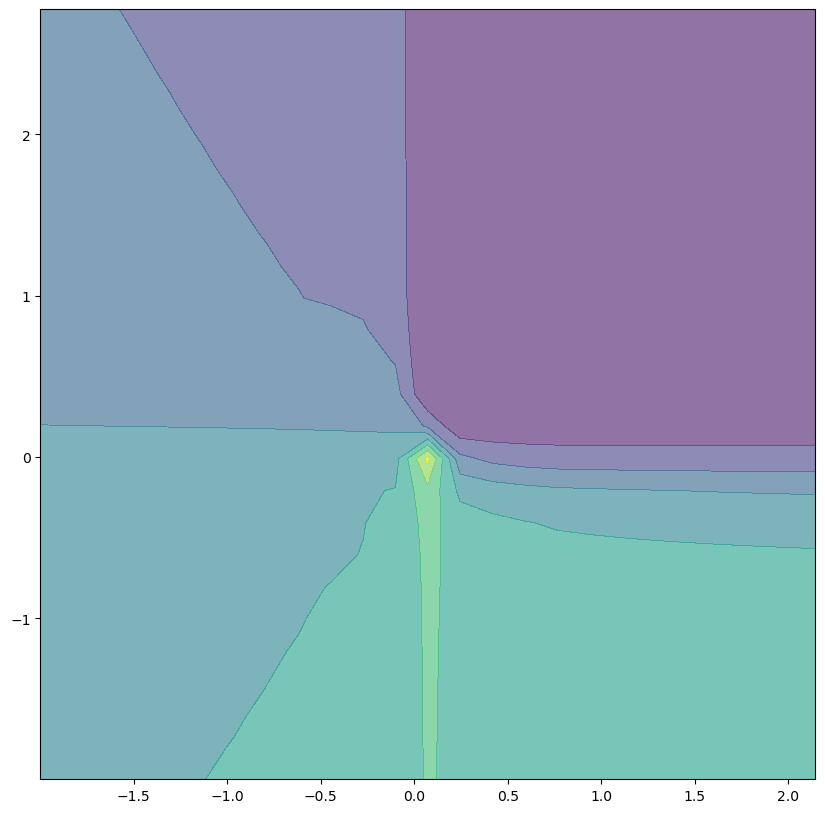

In [20]:
# PLOTTING Decision Boundaries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tabpfn.scripts.decision_boundary import DecisionBoundaryDisplay

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

# Plot the training points
vfunc = np.vectorize(lambda x : np.where(classifier.classes_ == x)[0])
y_train_index = vfunc(y_train)
y_train_index = y_train_index == 0

ax.scatter(X_train, X_train, c=y_train_index, cmap=cm_bright)

classifier.fit(X_train[:, 0:2], y_train)

DecisionBoundaryDisplay.from_estimator(
    classifier, X_train[:, 0:2], alpha=0.6, ax=ax, eps=2.0, grid_resolution=25, response_method="predict_proba"
)

# Submission

Once you are happy with your model, you can make a submission. To make a submission, you will need to use your model to make predictions about the presence of rice crops for a set of test coordinates we have provided in the <a href="https://challenge.ey.com/api/v1/storage/admin-files/6847912254281276-63ca8b5ab12e510013520e2b-challenge_1_submission_template.csv"><b>"challenge_1_submission_template.csv"</b></a> file and upload the file onto the challenge platform.

In [24]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template_correct_columns_fixed (1).csv')
test_file.head()

,id,target
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN


In [20]:
## Get Sentinel-1-RTC Data
time_slice = "2020-03-20/2020-03-21"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(test_file['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
submission_vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [04:53<00:00,  1.17s/it]


In [21]:
submission_vh_vv_data.head()

,vh,vv
0,0.003928,0.048405
1,0.016505,0.124807
2,0.036922,0.093570
3,0.002008,0.010407
4,0.063200,0.205140


In [22]:
# Feature Scaling 
submission_vh_vv_data = submission_vh_vv_data.values
transformed_submission_data = sc.transform(submission_vh_vv_data)

In [23]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [24]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Latitude and Longitude':test_file['Latitude and Longitude'].values, 'Class of Land':final_prediction_series.values})

In [25]:
#Displaying the sample submission dataframe
display(submission_df)

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Rice
4,"(10.20744446668854, 105.26844107128906)",Non Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Rice
246,"(10.582910017285496, 105.23991550078767)",Rice
247,"(10.581547330796518, 105.23991550078767)",Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [26]:
#Dumping the predictions into a csv file.
submission_df.to_csv("challenge_1_submission_rice_crop_prediction.csv",index = False)

## Conclusion

Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!